# Training a model

Below is the example for a Gaussian Process classification example using GpyTorch :class:`.VariationalGaussianProcessRegressor`

This example shows how to perform GP regression, but using variational inference rather than exact inference. 

In [1]:
# import gpytorch and gpwrapper in a directory above
import sys
sys.path.append("..")

import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpwrapper import VariationalGaussianProcessRegressor

%matplotlib inline

In [2]:
# Create a training set
# We're going to learn a sine function
train_x = torch.linspace(0, 1, 1000)
train_y = torch.sin(train_x * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2

In [3]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [4]:
# Step 1: Define the GP model
class GPRegressionModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPRegressionModel, self).__init__(grid_size=64, grid_bounds=[(-2, 2)])
        self.mean_module = gpytorch.means.ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = gpytorch.kernels.RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', torch.nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return gpytorch.random_variables.GaussianRandomVariable(mean_x, covar_x)

In [5]:
# Step 2: Wrap the model into our GP Wrapper
GPWrapper = VariationalGaussianProcessRegressor(
    module = GPRegressionModel,
    train_split = None,
    max_epochs = 40,
    scheduler = torch.optim.lr_scheduler.MultiStepLR
)

# Step 3: Find optimal model hyperparameters
# See dkl_mnist.ipynb for explanation of use_toeplitz
with gpytorch.settings.use_toeplitz(False), gpytorch.beta_features.diagonal_correction():
    GPWrapper.fit(X=train_x, y=train_y)
    
# Step 4: Prediction
test_x = torch.autograd.Variable(torch.linspace(0, 1, 51))
with gpytorch.settings.max_cg_iterations(2000), gpytorch.settings.use_toeplitz(False), gpytorch.beta_features.diagonal_correction():
    observed_pred = GPWrapper.predict_proba(X=test_x)

  epoch    train_loss     dur
-------  ------------  ------
      1      160.1326  0.1749
      2      112.6650  0.0619
      3       83.8052  0.0571
      4       67.7176  0.0563
      5       54.6686  0.0541
      6       40.9633  0.0575
      7       28.7714  0.0786
      8       20.1120  0.0670
      9       14.8302  0.0702
     10       11.5988  0.0637
     11        9.2122  0.0704
     12        7.8804  0.0563
     13        7.1130  0.0533
     14        7.2201  0.0546
     15        7.6093  0.0597
     16        8.0882  0.0566
     17        8.5868  0.0587
     18        8.9517  0.0564
     19        9.0864  0.0571
     20        8.9275  0.0650
     21        8.5280  0.0628
     22        7.9406  0.0650
     23        7.2908  0.0602
     24        6.6422  0.0568
     25        5.9429  0.0578
     26        5.2081  0.0662
     27        4.4777  0.0557
     28        3.8278  0.0557
     29        3.3090  0.0550
     30        2.9067  0.0550
     31        2.6257  0.0562
     32   

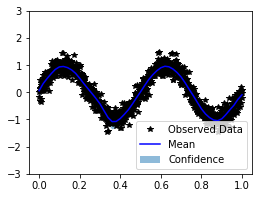

In [6]:
lower, upper = observed_pred.confidence_region()
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
ax.plot(test_x.data.cpu().numpy(), observed_pred.mean().data.cpu().numpy(), 'b')
ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Using Sklearn Pipeline
Same as skorch, our wrapper provides an sklearn-compatible interface, so it is possible to put it into an sklearn Pipeline. An example is shown below:

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('GP', GPWrapper),
])

pipe.fit(X=train_x.unsqueeze(-1), y=train_y)

  epoch    train_loss     dur
-------  ------------  ------
      1      154.1074  0.1020
      2      111.3461  0.1358
      3       84.1519  0.0968
      4       67.0284  0.0954
      5       53.0918  0.0984
      6       39.0577  0.0931
      7       26.6068  0.0920
      8       17.5448  0.1336
      9       11.9226  0.1121
     10        8.6647  0.1281
     11        6.8155  0.2047
     12        5.9278  0.1842
     13        6.0741  0.3196
     14        6.6459  0.1657
     15        7.5476  0.0907
     16        8.4454  0.3113
     17        9.2006  0.1302
     18        9.6477  0.0882
     19        9.8191  0.0862
     20        9.6600  0.1050
     21        9.2706  0.1673
     22        8.6795  0.1241
     23        7.9611  0.0885
     24        7.1674  0.0870
     25        6.3700  0.1834
     26        5.5993  0.1074
     27        4.8628  0.0868
     28        4.2076  0.0903
     29        3.6475  0.2002
     30        3.1964  0.1058
     31        2.8434  0.1116
     32   

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GP', <class 'gpwrapper.VariationalGaussianProcessRegressor'>[initialized](
  module_=GPRegressionModel(
    (mean_module): ConstantMean()
    (covar_module): GridKernel(
      (base_kernel_module): RBFKernel()
    )
  ),
))])

# Grid search
Same as skorch, another advantage of our wrapper is that you can perform an sklearn GridSearchCV or RandomizedSearchCV in Gpytorch to find optimal hyperparameters. Here is an example:

In [8]:
from sklearn.model_selection import GridSearchCV

GPWrapper = VariationalGaussianProcessRegressor(
    module = GPRegressionModel,
    train_split = None,
    max_epochs = 40,
    scheduler = torch.optim.lr_scheduler.MultiStepLR
)

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
}
gs = GridSearchCV(GPWrapper, params, refit=False, cv=3, scoring='r2',
                 return_train_score=False)  # Use a different scoring function maybe?

gs.fit(X=train_x, y=train_y)
print('\n gs.best_score_ = {}, gs.best_params = {}'.format(gs.best_score_, gs.best_params_))

  epoch    train_loss     dur
-------  ------------  ------
      1      259.9103  0.0744
      2      249.8280  0.0820
      3      240.5561  0.0778
      4      232.0551  0.0767
      5      224.2543  0.0750
      6      217.0878  0.0760
      7      210.4865  0.0749
      8      204.3922  0.1579
      9      198.7413  0.3527
     10      198.1927  0.1444
  epoch    train_loss     dur
-------  ------------  ------
      1      205.4134  0.1107
      2      196.1169  0.0813
      3      187.6001  0.1320
      4      179.8238  0.1295
      5      172.7172  0.1576
      6      166.2191  0.2016
      7      160.2486  0.1850
      8      154.7591  0.1647
      9      149.6802  0.1025
     10      149.1978  0.0967
  epoch    train_loss     dur
-------  ------------  ------
      1      164.2393  0.0949
      2      155.7902  0.1038
      3      148.1001  0.0864
      4      141.1123  0.1661
      5      134.7659  0.1341
      6      128.9964  0.3451
      7      123.7408  0.2135
      8   